In [2]:
!pip install transformers 

import time 
import datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
import pandas as pd 
import tensorflow as tf
import torch 

from sklearn.model_selection import train_test_split 

from torch.utils.data import TensorDataset, random_split 
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, BertConfig
from transformers import get_linear_schedule_with_warmup, AdamW


     |████████████████████████████████| 573kB 4.8MB/s 
     |████████████████████████████████| 890kB 20.2MB/s 
     |████████████████████████████████| 1.0MB 28.7MB/s 
     |████████████████████████████████| 3.7MB 47.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=05e55a0b268cf8d348a5e109e83a90ded388f5b81a013ce1935cf8e3b581258a
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# check for GPU 
device_name = tf.test.gpu_device_name()

if device_name == "/device:GPU:0":
  print("Found GPU at {}".format(device_name))
else:
  raise SystemError("GPU device not found")
  
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("There are {} GPU(s) available".format(torch.cuda.device_count()))
  print("We will use the GPU", torch.cuda.get_device_name(0))
else: 
  device = torch.device("cpu")
  print("No GPU available, we use the CPU instead")

Found GPU at /device:GPU:0
There are 1 GPU(s) available
We will use the GPU Tesla P100-PCIE-16GB


In [0]:
# loading the dataset 
url = "https://raw.githubusercontent.com/ant1code/tweet-sentiment/master/data/train.csv"
df = pd.read_csv(url)

# converting sentiment (categorical) to label (numerical)
# 0: negative, 1: neutral, 2: positive 
# FIXED: mapping was arbitrary
sentiment_to_label = {"negative": 0, "neutral": 1, "positive": 2}
df["label"]  = df.sentiment.map(sentiment_to_label) 

# drop irrelevant columns and rows with missing values 
df.drop(["textID", "selected_text", "sentiment"], axis=1, inplace=True)
df = df[df.text.notna()]

# convert all text to lowercase because we use uncased DistilBert 
# NOTE: try cased DistilBert also 
df.text = df.text.str.lower()

# get length of longest sentence in total dataset (train+valid+test)
# all sentences in Bert models must have the same length after tokenization 
# NOTE: does this count as using the test set? 
max_length = max(df.text.apply(len))

# split into train and test sets (80-20 split)
# this already shuffles the dataset 
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.2)

In [5]:
# load DistilBert tokenizer 
# NOTE: also try DistilBertTokenizerFast and distil-bert-cased
pretrained_weights = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)

In [0]:
# Bert formatting requirements: 
# - special tokens ([CLS], [SEP]) at start and end of every sentence 
# - all sentences have, or are padded to, the same length 
# - sentences have <= 512 tokens
# - each sentence has an "attention mask" that specifies where real tokens end 
#   and padding tokens begin 

token_ids = [] 
attention_masks = []

for text in x_train.values:
  encoded_dict = tokenizer.encode_plus(
      # NOTE: return_token_type_ids is None by default 
      # NOTE: what if the model is fed a sentence with #tokens > max_length?
      text, add_special_tokens=True, max_length=max_length,
      pad_to_max_length=True, return_attention_mask=True, return_tensors="pt"
  )

  token_ids.append(encoded_dict["input_ids"])
  attention_masks.append(encoded_dict["attention_mask"])

# create torch tensors size(train_set) x max_length
token_ids = torch.cat(token_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [0]:
labels = torch.tensor(y_train.values) 
dataset = TensorDataset(token_ids, attention_masks, labels)

# split into train and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

In [0]:
# create train and validation dataloaders
# DataLoaders are supposed to help reduce RAM usage by not loading the entire 
# dataset into memory 
# NOTE: also try batch_size=16
batch_size = 32

# NOTE: is sampling randomly necessary? we already shuffled the dataset at the start 
train_dataloader = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size
)

valid_dataloader = DataLoader(
    valid_dataset, sampler=SequentialSampler(valid_dataset), batch_size=batch_size
)

In [9]:
# load the (pretrained) classification model 
# DistilBertForSequenceClassification = DistilBert with a single linear layer 
# on top for sequence classification 
# NOTE: try BertForSequenceClassification? though it's a lot larger
model = BertForSequenceClassification.from_pretrained(pretrained_weights,
                                           num_labels=3, output_attentions=False, output_hidden_states=False
)

#model = DistilBertForSequenceClassification.from_pretrained(
 #   pretrained_weights, num_labels=3, output_attentions=False, output_hidden_states=False
#)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# optimizer with fixed weight decay - used in fine-tuning models
# NOTE: plot graphs to find best values for learning rate and epsilon?

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8) 

In [0]:
# NOTE: plot graphs to find best number of epochs
# Bert authors recommend only 2-4 epochs for reasons unknown
n_epochs = 2 # be careful colab keeps disconnecting due to inactivity
total_steps = len(train_dataloader) * n_epochs

# this scheduler has a learning rate that first increases linearly (this is 
# called the "warmup period") then decreases linearly 
# NOTE: try other schedules e.g. exponential decay
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

In [0]:
def flat_accuracy(logits, labels):
  # let prediction be the logit with highest value 
  pred_flat = np.argmax(logits, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed)) 
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
# for reproducibility purposes
# comment out for real training 

seed_val = 10 
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [14]:
# main training loop 
training_stats = []
early_stopping_models = {}
total_t0 = time.time()

for epoch_i in range(0, n_epochs): 
  print("")
  print("============== Epoch {:} / {:} ==============".format(epoch_i+1, n_epochs))
  print("Training...")

  t0 = time.time()
  total_train_loss = 0

  # put model in training mode 
  model.train() 
  
  for step, batch in enumerate(train_dataloader):
    # unpack input and labels 
    b_input_ids  = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels     = batch[2].to(device)

    # clear previously calculated gradients - must be done before backward pass! 
    model.zero_grad()

    # forward pass to evaluate model on this batch 
    # NOTE: without conversion to long, error occurs. but is there a more elegant method? 
    loss, logits = model(
        input_ids      = b_input_ids, 
        attention_mask = b_input_mask, 
        labels         = b_labels.long() 
    ) 

    # increment by this batch's training loss 
    total_train_loss += loss.item() 

    # backward pass to calculate gradients 
    loss.backward() 

    # limit gradients to 1.0 to avoid infinite gradients 
    # NOTE: try commenting this out too lol
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters (according to optimizer) 
    optimizer.step() 
    
    # update learning rate (according to scheduler)
    scheduler.step() 

    # print training progress every 100 batches 
    if step % 100 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print("  batch {:>5,} of {:>5,};    elapsed: {:}".format(step, len(train_dataloader), elapsed))

  # average training loss for this epoch 
  avg_train_loss = total_train_loss / len(train_dataloader)
  
  # time taken for training in this epoch
  training_time = format_time(time.time() - t0)

  print("")
  print("  average training loss: {0:.2f}".format(avg_train_loss))
  print("  time taken for training: {:}".format(training_time))

  print("")
  print("Running validation...")

  t0 = time.time() 
  total_eval_accuracy = 0
  total_eval_loss = 0 
  nb_eval_steps = 0 

  # put model in evaluation mode
  model.eval()

  for batch in valid_dataloader: 
    # unpack input and labels 
    b_input_ids  = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels     = batch[2].to(device).long()

    # disable gradient calculation, since there are no backward passes 
    with torch.no_grad(): 
      # forward pass to evaluate model on this batch 
      loss, logits = model(
          b_input_ids, attention_mask=b_input_mask, labels=b_labels
      ) 
    
    # increment by this batch's validation loss 
    total_eval_loss += loss.item()

    # move logits and labels to cpu 
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    total_eval_accuracy += flat_accuracy(logits, label_ids)

  # average validation statistics for this epoch
  avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
  avg_val_loss = total_eval_loss / len(valid_dataloader)
  valid_time = format_time(time.time() - t0)
  print("  accuracy: {0:.2f}".format(avg_val_accuracy))
  print("  validation loss: {0:.2f}".format(avg_val_loss))
  print("  time taken for validation: {:}".format(valid_time))
  
  valid_time = format_time(time.time() - t0)

  # record this epoch's train/validation statistics
  training_stats.append(
      {
          "epoch": epoch_i+1, 
          "training loss": avg_train_loss, 
          "valid. loss": avg_val_loss, 
          "valid. accuracy": avg_val_accuracy, 
          "training time": training_time, 
          "valid. time": valid_time
      }
  )

print("")
print("Training is complete.")
print("Training time: {:}".format(format_time(time.time() - total_t0)))


============== Epoch 1 / 2 ==============
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  batch   100 of   550;    elapsed: 0:00:50
  batch   200 of   550;    elapsed: 0:01:40
  batch   300 of   550;    elapsed: 0:02:29
  batch   400 of   550;    elapsed: 0:03:19
  batch   500 of   550;    elapsed: 0:04:08

  average training loss: 0.63
  time taken for training: 0:04:32

Running validation...
  accuracy: 0.79
  validation loss: 0.52
  time taken for validation: 0:00:22

============== Epoch 2 / 2 ==============
Training...
  batch   100 of   550;    elapsed: 0:00:50
  batch   200 of   550;    elapsed: 0:01:39
  batch   300 of   550;    elapsed: 0:02:29
  batch   400 of   550;    elapsed: 0:03:18
  batch   500 of   550;    elapsed: 0:04:08

  average training loss: 0.43
  time taken for training: 0:04:32

Running validation...
  accuracy: 0.80
  validation loss: 0.53
  time taken for validation: 0:00:22

Training is complete.
Training time: 0:09:47


In [15]:
# summary of fine-tuning 
pd.set_option("precision", 2)
training_stats = pd.DataFrame(data=training_stats)
training_stats = training_stats.set_index("epoch")

training_stats

,training loss,valid. loss,valid. accuracy,training time,valid. time
epoch,,,,,
1,0.63,0.52,0.79,0:04:32,0:00:22
2,0.43,0.53,0.80,0:04:32,0:00:22


([<matplotlib.axis.XTick at 0x7f2c9a2eecf8>,
 <a list of 2 Text major ticklabel objects>)

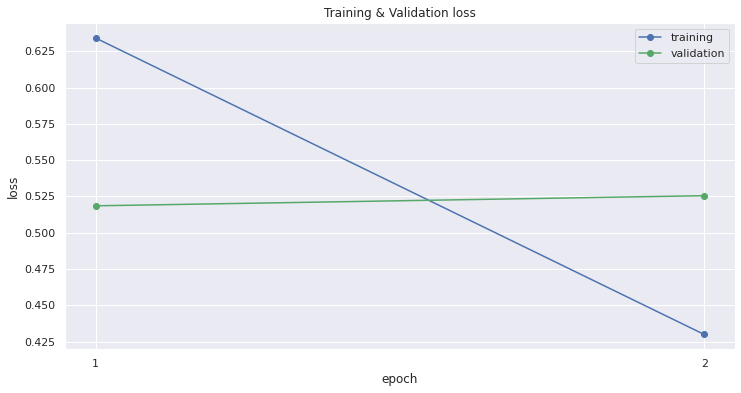

In [16]:
# plot training and validation loss to detect over/underfitting
% matplotlib inline

sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

plt.plot(training_stats["training loss"], "b-o", label="training")
plt.plot(training_stats["valid. loss"], "g-o", label="validation")

plt.title("Training & Validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.xticks(range(1,n_epochs+1))

In [0]:
# re-do of entire training process, but with lower number of epochs 
# NOTE: try to implement early stopping/caching of good models? 
n_epochs = np.argmin(training_stats["valid. loss"]) + 1


In [0]:
# for now, just use the overfitting model anyway on the test set 

token_ids = [] 
attention_masks = []

for text in x_test.values:
  encoded_dict = tokenizer.encode_plus(
      text, add_special_tokens=True, max_length=max_length,
      pad_to_max_length=True, return_attention_mask=True, return_tensors="pt"
  )

  token_ids.append(encoded_dict["input_ids"])
  attention_masks.append(encoded_dict["attention_mask"])

token_ids = torch.cat(token_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

labels = torch.tensor(y_test.values) 
dataset = TensorDataset(token_ids, attention_masks, labels)

batch_size = 32 
test_dataloader = DataLoader(
    dataset, sampler=SequentialSampler(dataset), batch_size=batch_size
)

In [19]:
# evaluating model on test_dataloader 

predictions = [] 
total_test_accuracy = 0

model.eval() 

for batch in test_dataloader:  
  b_input_ids  = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels     = batch[2].to(device).long()

  with torch.no_grad():
    output = model(
        b_input_ids, attention_mask=b_input_mask
    )

  logits = output[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to("cpu").numpy()

  predictions.append(logits)
  total_test_accuracy += flat_accuracy(logits, label_ids)

avg_test_accuracy = total_test_accuracy / len(test_dataloader)
print("  test accuracy: {:}".format(avg_test_accuracy))

  test accuracy: 0.7890915697674419
